## WS25: Seminar: Business Analytics (Master) - BWL 12
### Topic: Supply Chain Resilience under Disruptions — An Agent-Based Simulation with Mesa

In [1]:
from model import MultiTierModel
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [2]:
# ---------------------------
# Assumptions & strategies
# ---------------------------
assumptions = {
    "n_suppliers": 2,
    "n_plants": 1,
    "n_dcs": 1,
    "n_retailers": 3,
    "base_stock": {"supplier": 100, "plant": 80, "dc": 60, "retailer": 30},
    "capacity": {"supplier": 20, "plant": 15, "dc": 10, "retailer": 0},
    "lead_time": {"supplier": 1, "plant": 5, "dc": 5, "retailer": 2},
    "capacity_loss_frac": 0.6,
    "recovery_duration": 6,
    "holding_cost": 1.0,
    "backlog_cost": 5.0,
    "retailer_demand_mean": 5.0
}

n_steps = 50
scenarios = ["capacity_loss", "lead_time_surge", "demand_spike"]

strategy_configs = {
    "baseline": {"dual_sourcing": False, "safety_stock_factor": 1.0, "flexible_capacity": False, "dynamic_reallocation": False},
    "dual_only": {"dual_sourcing": True, "safety_stock_factor": 1.0, "flexible_capacity": False, "dynamic_reallocation": False},
    "safety_only": {"dual_sourcing": False, "safety_stock_factor": 1.5, "flexible_capacity": False, "dynamic_reallocation": False},
    "flex_only": {"dual_sourcing": False, "safety_stock_factor": 1.0, "flexible_capacity": True, "dynamic_reallocation": False},
    "dynalloc_only": {"dual_sourcing": False, "safety_stock_factor": 1.0, "flexible_capacity": False, "dynamic_reallocation": True},
    "all_strategies": {"dual_sourcing": True, "safety_stock_factor": 1.5, "flexible_capacity": True, "dynamic_reallocation": True}
}

results = {}

# run experiments
for scenario in scenarios:
    print(f"\n=== Scenario: {scenario} ===")
    for sname, sconf in strategy_configs.items():
        print(f" Running strategy: {sname}")
        model = MultiTierModel(assumptions=assumptions, seed=SEED,
                               strategies=sconf, disruption_at_step=10, scenario=scenario)
        fill_rates = []
        total_costs = []
        for t in range(n_steps):
            model.step()
            fill_rates.append(model.compute_fill_rate())
            total_costs.append(model.compute_total_cost())
        df = pd.DataFrame({"step": range(n_steps), "fill_rate": fill_rates, "total_cost": total_costs})
        bullwhip = model.compute_bullwhip()
        backlog_duration = model.compute_backlog_duration()
        ttr = model.compute_time_to_recover()
        results[(scenario, sname)] = {"df": df, "bullwhip": bullwhip, "backlog_duration": backlog_duration, "ttr": ttr}
        print(f"  Final fill: {fill_rates[-1]:.3f} | total_cost: {total_costs[-1]:.1f} | bullwhip: {bullwhip:.3f} | backlog_dur: {backlog_duration:.1f} | TTR: {ttr}")



=== Scenario: capacity_loss ===
 Running strategy: baseline
[Disruption] t=10 scenario=capacity_loss victim=<Firm 0 supplier Inv:100 Bk:0 Pipe:0>
  Final fill: 0.776 | total_cost: 31766.0 | bullwhip: 0.000 | backlog_dur: 38.7 | TTR: 1
 Running strategy: dual_only
[Disruption] t=10 scenario=capacity_loss victim=<Firm 2 plant Inv:80 Bk:0 Pipe:0>
  Final fill: 0.776 | total_cost: 31737.0 | bullwhip: 0.003 | backlog_dur: 38.7 | TTR: 1
 Running strategy: safety_only
[Disruption] t=10 scenario=capacity_loss victim=<Firm 0 supplier Inv:150 Bk:0 Pipe:0>
  Final fill: 1.000 | total_cost: 25219.0 | bullwhip: 0.133 | backlog_dur: 0.0 | TTR: 1
 Running strategy: flex_only
[Disruption] t=10 scenario=capacity_loss victim=<Firm 0 supplier Inv:150 Bk:0 Pipe:0>
  Final fill: 1.000 | total_cost: 25252.0 | bullwhip: 0.020 | backlog_dur: 0.0 | TTR: 1
 Running strategy: dynalloc_only
[Disruption] t=10 scenario=capacity_loss victim=<Firm 0 supplier Inv:150 Bk:0 Pipe:0>
  Final fill: 1.000 | total_cost: 252

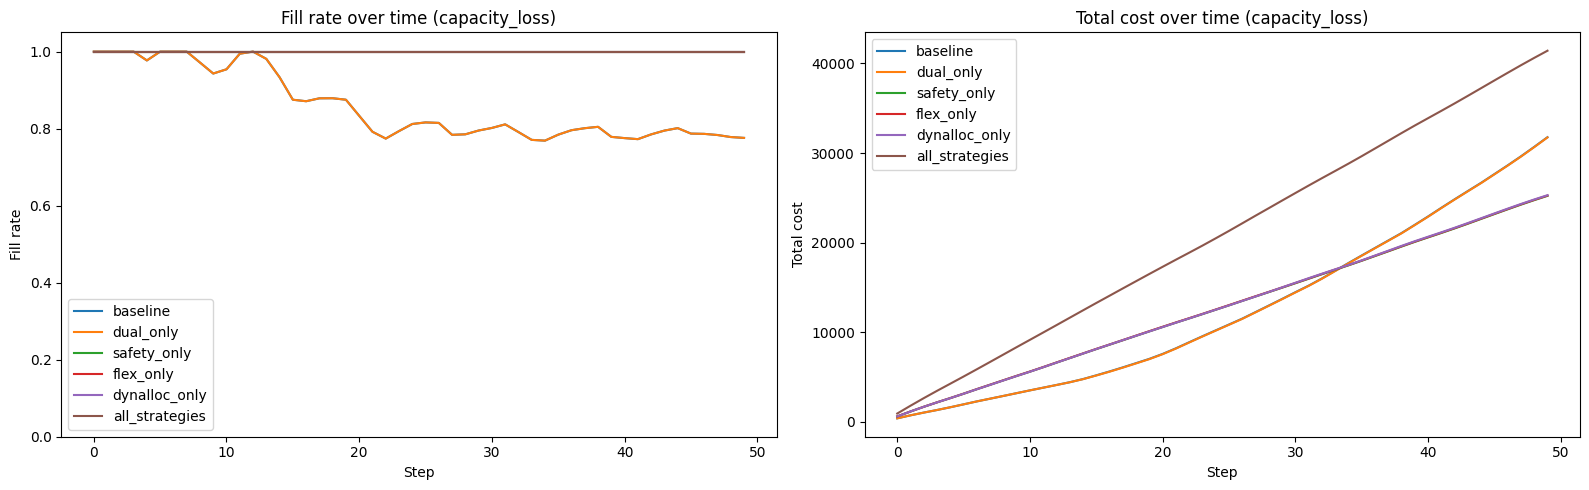


Summary (scenario = capacity_loss)
         strategy  final_fill  final_cost  bullwhip  backlog_duration  \
3       flex_only     1.00000     25252.0  0.019656          0.000000   
2     safety_only     1.00000     25219.0  0.132506          0.000000   
4   dynalloc_only     1.00000     25293.0  0.138224          0.000000   
5  all_strategies     1.00000     41416.0  0.519769          0.000000   
1       dual_only     0.77591     31737.0  0.003470         38.666667   
0        baseline     0.77591     31766.0  0.000441         38.666667   

   time_to_recover  
3                1  
2                1  
4                1  
5                1  
1                1  
0                1  


In [3]:
# ---------------------------
# Plot example (capacity_loss)
# ---------------------------
sel_scenario = "capacity_loss"
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
for sname in strategy_configs:
    df = results[(sel_scenario, sname)]["df"]
    plt.plot(df["step"], df["fill_rate"], label=sname)
plt.title(f"Fill rate over time ({sel_scenario})")
plt.xlabel("Step")
plt.ylabel("Fill rate")
plt.ylim(0,1.05)
plt.legend()

plt.subplot(1,2,2)
for sname in strategy_configs:
    df = results[(sel_scenario, sname)]["df"]
    plt.plot(df["step"], df["total_cost"], label=sname)
plt.title(f"Total cost over time ({sel_scenario})")
plt.xlabel("Step")
plt.ylabel("Total cost")
plt.legend()
plt.tight_layout()
plt.show()

# summary table
rows = []
for sname in strategy_configs:
    out = results[(sel_scenario, sname)]
    rows.append({
        "strategy": sname,
        "final_fill": out["df"]["fill_rate"].iloc[-1],
        "final_cost": out["df"]["total_cost"].iloc[-1],
        "bullwhip": out["bullwhip"],
        "backlog_duration": out["backlog_duration"],
        "time_to_recover": out["ttr"]
    })
summary_df = pd.DataFrame(rows).sort_values("final_fill", ascending=False)
print("\nSummary (scenario = {})".format(sel_scenario))
print(summary_df)